In [98]:
import os
import numpy as np
import pandas as pd
import keras
import keras.layers as kl
import keras.callbacks
import keras.optimizers
import tensorflow as tf
import keras.utils as ku
import matplotlib.pyplot as plt
import skimage.color as ski
import skimage.io as skio
from tqdm import tqdm

In [71]:
def load_images(images_paths: list, target_size=(400,400)):
    X = []
    Y = []
    for path in tqdm(images_paths):
        img = ku.load_img(path, target_size=target_size,keep_aspect_ratio=True)
        img = ku.img_to_array(img)
        img = np.array(img, dtype=float)
        X.append(tf.constant(ski.rgb2lab(1.0/255*img)[...,0]))
        Y.append(tf.constant(ski.rgb2lab(1.0/255*img)[...,1:]))

    return np.array(X), np.array(Y)

In [105]:
def to_img(path):
    image = ku.img_to_array(ku.load_img(path, target_size=(400,400)))
    image = np.array(image, dtype=float)
    X = ski.rgb2lab(1.0/255*image)[:,:,0]
    X = X.reshape(1, 400, 400, 1)

    output = model.predict(X)
    output *= 128
    # Output colorizations
    cur = np.zeros((400, 400, 3))
    cur[:,:,0] = X[0][:,:,0]
    cur[:,:,1:] = output[0]
    return ski.lab2rgb(cur)


In [72]:
base_path = '/app/data/imagenet_data/'
train_path = os.path.join(base_path, 'train/color')
vali_path = os.path.join(base_path, 'vali/color')
train_paths = [os.path.join(train_path, img) for img in os.listdir(train_path)]
vali_paths = [os.path.join(vali_path, img) for img in os.listdir(vali_path)]

In [103]:
X, Y = load_images(train_paths[1000:2000])
vX, vY = load_images(vali_paths[:100])

100%|██████████| 100/100 [00:02<00:00, 35.67it/s]


In [79]:
# Building the neural network
model = keras.Sequential()
model.add(kl.InputLayer(input_shape=(None, None, 1)))
model.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
model.add(kl.Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(kl.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(kl.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
model.add(kl.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(kl.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
model.add(kl.UpSampling2D((2, 2)))
model.add(kl.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(kl.UpSampling2D((2, 2)))
model.add(kl.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(kl.UpSampling2D((2, 2)))
model.add(kl.Conv2D(2, (3, 3), activation='tanh', padding='same'))

In [80]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, None, None, 8)     80        
                                                                 
 conv2d_28 (Conv2D)          (None, None, None, 8)     584       
                                                                 
 conv2d_29 (Conv2D)          (None, None, None, 16)    1168      
                                                                 
 conv2d_30 (Conv2D)          (None, None, None, 16)    2320      
                                                                 
 conv2d_31 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 conv2d_32 (Conv2D)          (None, None, None, 32)    9248      
                                                                 
 up_sampling2d_9 (UpSampling  (None, None, None, 32)  

In [84]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [85]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001), loss='mse')

In [104]:
hist = model.fit(x=X,  y=Y, batch_size=1, epochs=1000, callbacks=[early_stopping], validation_data=(vX, vY))

Epoch 1/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 248.0345 - val_loss: 268.1495
Epoch 2/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 248.0965 - val_loss: 268.3237
Epoch 3/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 248.1261 - val_loss: 267.9820
Epoch 4/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 248.0620 - val_loss: 268.1625
Epoch 5/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 248.0464 - val_loss: 268.0819
Epoch 6/1000
1000/1000 [==============================] - 4s 4ms/step - loss: 248.0595 - val_loss: 268.2382
Epoch 7/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 248.0747 - val_loss: 268.0229
Epoch 8/1000
1000/1000 [==============================] - 5s 5ms/step - loss: 248.0708 - val_loss: 268.0219


In [108]:
test_dir = '/app/data/imagenet_data/test/color/'
img_paths = [ os.path.join(test_dir, f) for f in os.listdir(test_dir) ]

1/1 [==============================] - 0s 11ms/step


/tmp/ipykernel_253/1504562146.py:13: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 99098 negative Z values that have been clipped to zero
  return ski.lab2rgb(cur)


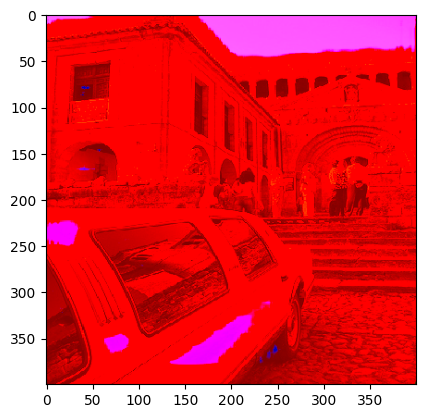

In [117]:
img = to_img(img_paths[8])
plt.imshow(img)

In [118]:
model.save('/app/models/alpha_version_tanh.h5')